# Таргет для машинок с Авито

## Подключение 

In [5]:
import sys 
print(f"Версия Python: {sys.version}")

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

import os
import re 

from src.tools import save_photo

from tqdm import tqdm 
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning, DeprecationWarning])

print('numpy:', np.__version__)
print('pandas:', pd.__version__)

Версия Python: 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]
numpy: 1.26.4
pandas: 2.2.2


## Данные (avito)

In [6]:
folders = ['data', 'data2', 'data3', 'data4', 'data5', 'data6', 'data8']
dfs = []

for folder in folders:
    for filename in os.listdir(folder):
        if filename.endswith('.parquet'): 
            filepath = os.path.join(folder, filename)
            current_df = pd.read_parquet(filepath)
            dfs.append(current_df)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)

df = df.drop_duplicates(subset=['link'])
df = df.dropna()
print(df.shape)

(18541, 7)
(11240, 7)


In [40]:
df['characteristics'].iloc[0]

['Год выпуска:2011',
 'Поколение:I (2007—2013)',
 'Пробег:152\xa0406\xa0км',
 'История пробега:2 записи в\xa0отчёте Автотеки',
 'ПТС:Оригинал',
 'Владельцев по ПТС:4+',
 'Состояние:Битый',
 'Модификация:1.6 MT (87 л.с.)',
 'Объём двигателя:1.6\xa0л',
 'Тип двигателя:Бензин',
 'Коробка передач:Механика',
 'Привод:Передний',
 'Комплектация:Базовая',
 'Тип кузова:Седан',
 'Цвет:Чёрный',
 'Руль:Левый',
 'VIN или номер кузова:XTA2*************',
 'Обмен:Не интересует']

In [7]:
def get_damage_status(lst):
    lst = list(filter(lambda x: 'Состояние' in x, lst))
    if len(lst) > 0: 
        return lst[0].replace('Состояние:', '')
    
def get_year(lst):
    lst = list(filter(lambda x: 'Год выпуска' in x, lst))
    if len(lst) > 0: 
        return int(lst[0].replace('Год выпуска:', ''))

def get_run(lst):
    lst = list(filter(lambda x: 'Пробег' in x, lst))
    if len(lst) > 0: 
        return int(re.sub(r'\xa0|км', '', lst[0].replace('Пробег:', '')))



df['price'] = df['price'].astype(float)
df['year'] = df['characteristics'].apply(get_year)
df['run'] = df['characteristics'].apply(get_run)
df['damaged'] = df['characteristics'].apply(get_damage_status)

df = df.dropna()
print(df.shape[0])

10572


## Данные (kaggle)

In [8]:
kaggle_df = pd.read_csv('Churn_Modelling.csv')

kaggle_df["Gender"] = kaggle_df["Gender"].apply(lambda x: int(x == "Male")).astype("uint8")


def geography_int(x: str) -> int:
    if x == "France":
        return 0
    elif x == "Germany":
        return 1
    elif x == "Spain":
        return 2

kaggle_df["Geography"] = kaggle_df["Geography"].fillna(kaggle_df["Geography"].value_counts().index[0])
kaggle_df["Geography"] = kaggle_df["Geography"].apply(geography_int).astype("uint8")
kaggle_df["Age"] = kaggle_df["Age"].fillna(kaggle_df["Age"].median())
kaggle_df["Age"] = kaggle_df["Age"].astype("uint8")
kaggle_df["HasCrCard"] = kaggle_df["HasCrCard"].fillna(kaggle_df["HasCrCard"].value_counts().index[0])
data["HasCrCard"] = data["HasCrCard"].astype("uint8")
data["IsActiveMember"] = data["IsActiveMember"].fillna(data["IsActiveMember"].value_counts().index[0])
data["IsActiveMember"] = data["IsActiveMember"].astype("uint8")
data["Tenure"] = data["Tenure"].astype("uint8")
data["NumOfProducts"] = data["NumOfProducts"].astype("uint8")
data["Exited"] = data["Exited"].astype("uint8")
data["Age"] = data["Age"].astype("uint8")

kaggle_df[:5]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,43,2,125510.82,1,1,1,79084.10,0


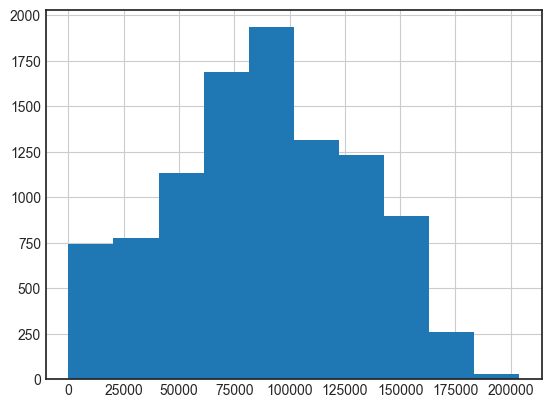

In [9]:
alpha = 0.5

(alpha * kaggle_df['EstimatedSalary'] + (1 - alpha) * kaggle_df['Balance']).hist()
plt.show()

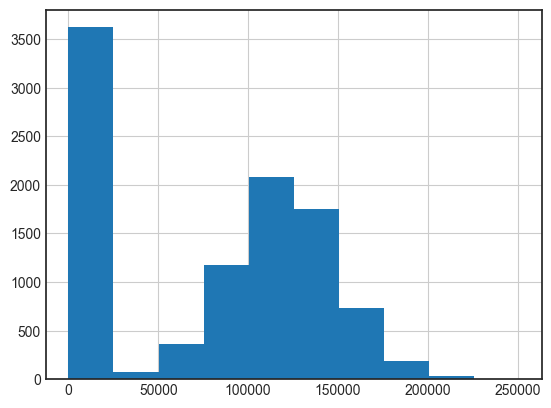

In [10]:
kaggle_df['Balance'].hist()
plt.show()

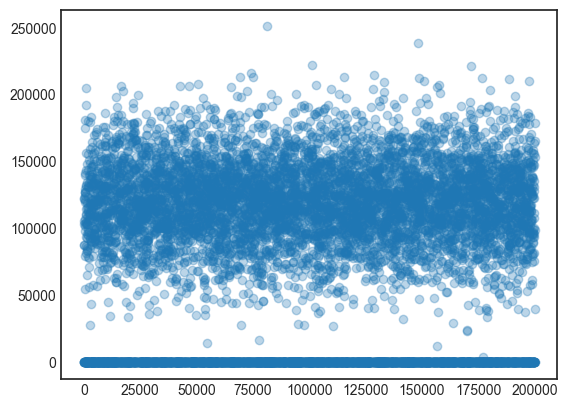

In [11]:
plt.scatter(kaggle_df['EstimatedSalary'], kaggle_df['Balance'], alpha=0.3)
plt.show()

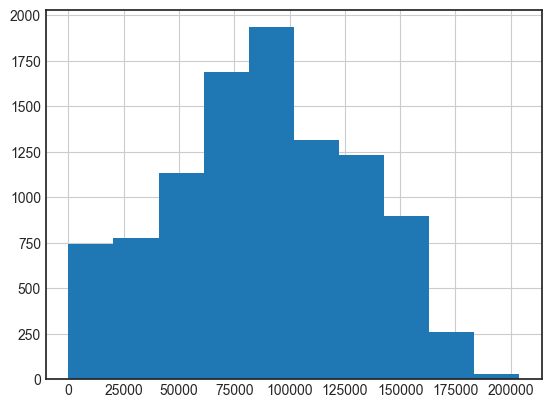

In [12]:
alpha = 0.5

kaggle_df['income'] = (alpha * kaggle_df['EstimatedSalary'] + (1 - alpha) * kaggle_df['Balance']) 
kaggle_df['income'].hist() 
plt.show()

## Соединим данные по бинам 

In [20]:
num_bins = 6
bin_labels = list(range(num_bins))

kaggle_df['bin'], bins = pd.qcut(kaggle_df['income'], q=num_bins, retbins=True, labels=bin_labels)
print(kaggle_df['bin'].value_counts())

df['bin'], bins = pd.qcut(df['price'], q=num_bins, retbins=True, labels=bin_labels)
print(df['bin'].value_counts())

bin
0    1667
1    1667
2    1667
3    1667
4    1667
5    1667
Name: count, dtype: int64
bin
0    1784
3    1768
2    1765
5    1758
4    1754
1    1743
Name: count, dtype: int64


In [33]:
df[:1]

,title,price,characteristics,description,location,link,photo,year,run,damaged,bin
0,"Skoda Rapid 1.6 AT, 2017, 86 000 км",1450000.0,"[Год выпуска:2017, Поколение:I рестайлинг (2017—2020), Пробег:86 000 км, История пробега:6 записей в отчёте Автотеки, ПТС:Оригинал, Владельцев по ПТС:2, Состояние:Не битый, Модификация:1.6 MPI AT (110 л.с.), Объём двигателя:1.6 л, Тип двигателя:Бензин, Коробка передач:Автомат, Привод:Передний, Комплектация:Style, Тип кузова:Лифтбек, Цвет:Коричневый, Руль:Левый, VIN или номер кузова:XW8A*************, Обмен:Не интересует]","Новую машину уже купил, просьба своих цен не предлагать делал оценку в трейд ин, стоимость уточнил. Комплектация очень богатая на климате, остальное на фото. Вложений не требует. Подробности уточняйте по телефону, с деньгами у капота торг гарантирую.","Саратовская обл., Саратов, Ленинский район",https://www.avito.ru/saratov/avtomobili/skoda_rapid_1.6_at_2017_86_000_km_4296677504,"[https://20.img.avito.st/image/1/1.7cOyQLa4QSqE6YMv5APp7pjhQywM4cMixORDKALpSSAE.PJPufwrPHynMpbqtrngt96zvjFmYIbmhurdg1r2J_UI, https://00.img.avito.st/image/1/1.KBvDZra4hPL1z0b3nzZxTtPHhvR9xwb6tcKG8HPPjPh1.-XloAtviGaYL1cyMfy9QiaoMhDcXx6F6seh0tITahFY, https://00.img.avito.st/image/1/1.5VMMbba4Sbo6xIu_Sl64BhzMS7yyzMuyeslLuLzEQbC6.YuaMJBef3X3mcV4aeRUPwwyDujnXwywrpj14wcizMpk, https://80.img.avito.st/image/1/1.gmu_cra4LoKJ2-yHt0SNRpXTLIQB06yKydYsgA_bJogJ.BbPkrE51PhJQY_OhOPCEU4vWha8nMc0Ufi_york8Si4, https://00.img.avito.st/image/1/1.vrO2P7a4ElqAltBfxgm7npyeEFwInpBSwJsQWAaWGlAA.x3OoY1-UDf-ng0C5P7-zTRPwB0n0O7z0CMRYMxa9StU]",2017.0,86000.0,Не битый,5


In [35]:
dfs = [] 

for i in range(num_bins): 
    print(kaggle_df[kaggle_df['bin'] == i].shape[0])
    dfs.append(pd.concat([
        df[df['bin'] == i].sample(kaggle_df[kaggle_df['bin'] == i].shape[0]).reset_index(drop=True), 
        kaggle_df[kaggle_df['bin'] == i].reset_index(drop=True)
    ], axis=1))

res = pd.concat(dfs)
res = res.drop(columns=['bin'])
res.to_parquet('Churn_Modelling_processed_with_photo.parquet')
print(res.shape)

1667
1667
1667
1667
1667
1667
(10002, 25)


In [36]:
res[:1]

,title,price,characteristics,description,location,link,photo,year,run,damaged,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,income
0,"ВАЗ (LADA) Priora 1.6 MT, 2011, битый, 152 406 км",200000.0,"[Год выпуска:2011, Поколение:I (2007—2013), Пробег:152 406 км, История пробега:2 записи в отчёте Автотеки, ПТС:Оригинал, Владельцев по ПТС:4+, Состояние:Битый, Модификация:1.6 MT (87 л.с.), Объём двигателя:1.6 л, Тип двигателя:Бензин, Коробка передач:Механика, Привод:Передний, Комплектация:Базовая, Тип кузова:Седан, Цвет:Чёрный, Руль:Левый, VIN или номер кузова:XTA2*************, Обмен:Не интересует]",Продаётся Лада Приора2011 г.Съехала в кюветСостояние на фотоЦена договорнаяТелефон на последнем фото,"Самарская обл., Ставропольский р-н, сельское поселение Хрящёвка, с. Хрящёвка, Советская ул., 3",https://www.avito.ru/hryaschevka/avtomobili/vaz_lada_priora_1.6_mt_2011_bityy_152_406_km_4231821970,"[https://20.img.avito.st/image/1/1._HikLba4UJGShJKU0Gq9ZrqMUpcajNKZ0olSkxSEWJsS.GC-Vd9aWr1sfRy6NxfEdcZQjjukImJRfdHapstlR2kI, https://20.img.avito.st/image/1/1.BKcB-7a4qE43UmpLBfcNsSlaqki_WipGd1-qTLFSoES3.MlfeN8MrTWu1R4l2SMgMdXal5isMdXLroB86IhHd7uA, https://20.img.avito.st/image/1/1.jYhGOra4IWFwk-NkUBSJnm6bI2f4m6NpMJ4jY_aTKWvw.NIQ4FZahIcJ3NvubPtbIZWYopnZuJHPGeAe1PoV37uk, https://60.img.avito.st/image/1/1.8INfmba4XGppMJ5vM-qwnUE4XmzhON5iKT1eaO8wVGDp.QVUG_bcC7wd9huI9LRf72PbOuU5Xmmdvda0TpoJEG7c, https://60.img.avito.st/image/1/1.dXLbK7a42ZvtghuevTp_ZPOK251liluTrY_bmWuC0ZFt.Au5YpH63zgT0OnPwQSjajtu-O5B88Aposz9gt7hteMc]",2011.0,152406.0,Битый,7,15592531,Bartlett,822,0,1,50,7,0.0,2,1,1,10062.8,0,5031.4


## Скачаем фотографии 

In [38]:
df = pd.read_parquet("Churn_Modelling_processed_with_photo.parquet")

output_folder = "photos"
os.makedirs(output_folder, exist_ok=True)

exploded_df = df.explode('photo', ignore_index=True)
exploded_df['photo_name'] = exploded_df['photo'].apply(lambda x: x[-40:])

_ = exploded_df.progress_apply(lambda x: save_photo(
    photo_url=x['photo'], 
    photo_name=f"{output_folder}/{x['photo_name']}.jpg"
), axis=1)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.03it/s]


In [39]:
exploded_df[['photo', 'photo_name']][:10]

,photo,photo_name
0,https://20.img.avito.st/image/1/1._HikLba4UJGShJKU0Gq9ZrqMUpcajNKZ0olSkxSEWJsS.GC-Vd9aWr1sfRy6NxfEdcZQjjukImJRfdHapstlR2kI,Vd9aWr1sfRy6NxfEdcZQjjukImJRfdHapstlR2kI
1,https://20.img.avito.st/image/1/1.BKcB-7a4qE43UmpLBfcNsSlaqki_WipGd1-qTLFSoES3.MlfeN8MrTWu1R4l2SMgMdXal5isMdXLroB86IhHd7uA,eN8MrTWu1R4l2SMgMdXal5isMdXLroB86IhHd7uA
2,https://20.img.avito.st/image/1/1.jYhGOra4IWFwk-NkUBSJnm6bI2f4m6NpMJ4jY_aTKWvw.NIQ4FZahIcJ3NvubPtbIZWYopnZuJHPGeAe1PoV37uk,4FZahIcJ3NvubPtbIZWYopnZuJHPGeAe1PoV37uk
3,https://60.img.avito.st/image/1/1.8INfmba4XGppMJ5vM-qwnUE4XmzhON5iKT1eaO8wVGDp.QVUG_bcC7wd9huI9LRf72PbOuU5Xmmdvda0TpoJEG7c,G_bcC7wd9huI9LRf72PbOuU5Xmmdvda0TpoJEG7c
4,https://60.img.avito.st/image/1/1.dXLbK7a42ZvtghuevTp_ZPOK251liluTrY_bmWuC0ZFt.Au5YpH63zgT0OnPwQSjajtu-O5B88Aposz9gt7hteMc,YpH63zgT0OnPwQSjajtu-O5B88Aposz9gt7hteMc
5,https://40.img.avito.st/image/1/1.S7lCaba451B0wCVVWGA4-FzI5Vb8yGVYNM3lUvLA71r0.BF1dNqzQYQou-3JVMecG1H6AQS4ZnT-gwQkWcRyahwU,dNqzQYQou-3JVMecG1H6AQS4ZnT-gwQkWcRyahwU
6,https://60.img.avito.st/image/1/1.P6cTmLa4k04lMVFLYbhM5g05kUitORFGZTyRTKMxm0Sl.IPwC-2fKzZthYEsMUIizT60JvBrWa4guLg6uIB8REEo,C-2fKzZthYEsMUIizT60JvBrWa4guLg6uIB8REEo
7,https://00.img.avito.st/image/1/1.yB065ra4ZPQMT6bxJvX-RBJHZvKER-b8TEJm9opPbP6M.-3JpiYXSSNDZAhFAZ-Ag15m7GbZ3G_6UHi-YoO17aC4,piYXSSNDZAhFAZ-Ag15m7GbZ3G_6UHi-YoO17aC4
8,https://20.img.avito.st/image/1/1.jZOG5La4IXqwTeN_kKqSua1FI3w4RaNy8EAjeDZNKXAw.iHES3MFWdge8b_j3N5QpRZdYGgR0_lEYP82VwQ8rd2I,S3MFWdge8b_j3N5QpRZdYGgR0_lEYP82VwQ8rd2I
9,https://40.img.avito.st/image/1/1.S7lCaba351Biy4v-XhdP-vbK51r8XOQ89Mo.mBNxW7S5dEZInbHXsHqs6LiuAXO31tTHJdqArYX6yXM,xW7S5dEZInbHXsHqs6LiuAXO31tTHJdqArYX6yXM
